### Goal: Simple Regressions...

So what we want is to work through the trade and county-level data set so that we can perform basic regressions: for instance exports on the change in tariffs. 

**This is a core notebook to the project** so I will try and explain each step clearly. It will also output the county-level trade data set as a `.parquet` file.

In [1]:
import pandas as pd             # data package
import matplotlib.pyplot as plt # graphics 
import datetime as dt
import numpy as np

import requests, io             # internet and input tools  
import zipfile as zf            # zip file tools 
import os  

#import weightedcalcs as wc
#import numpy as np

import pyarrow as pa
import pyarrow.parquet as pq

import statsmodels.formula.api as smf
from linearmodels.iv import IV2SLS
from linearmodels.panel import PanelOLS

C:\ProgramData\Anaconda3\lib\site-packages\linearmodels\panel\data.py:10: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import (Categorical, DataFrame, Index, MultiIndex, Panel, Series,


### Step 1 Grab and manipulate the county level data for 2017

So we will grab the single file, then adjust it to suit our needs. The needs are to construct county-level employment weights to create a trade exposure metric and tariff metric for each county.

In [2]:
url = "https://data.bls.gov/cew/data/files/2017/csv/2017_annual_singlefile.zip"
# This will read in the annual, single file. It's big, but has all we want...

r = requests.get(url) 

# convert bytes to zip file  
bls_sf = zf.ZipFile(io.BytesIO(r.content)) 
print('Type of zipfile object:', type(bls_sf))

clist = ['area_fips', 'own_code', 'industry_code', 'agglvl_code', 'size_code',
       'year', 'disclosure_code', 'annual_avg_estabs',
       'annual_avg_emplvl', 'total_annual_wages','avg_annual_pay']

df = pd.read_csv(bls_sf.open(bls_sf.namelist()[0]), usecols= clist)

# SHOULD PRESPECIFY TYPES TO 

df.head()


Type of zipfile object: <class 'zipfile.ZipFile'>


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,area_fips,own_code,industry_code,agglvl_code,size_code,year,disclosure_code,annual_avg_estabs,annual_avg_emplvl,total_annual_wages,avg_annual_pay
0,1000,0,10,50,0,2017,NaN,124881,1936819,89088710816,45997
1,1000,1,10,51,0,2017,NaN,1208,53131,4339038631,81668
2,1000,1,102,52,0,2017,NaN,1208,53131,4339038631,81668
3,1000,1,1021,53,0,2017,NaN,610,11173,716001109,64083
4,1000,1,1022,53,0,2017,NaN,2,12,369309,30354


Then the file below cleans stuff up. The most important is the `NAICS_county_level` which selects the NAICS aggregation and then the county aggregation. Website describing this is here:

[https://data.bls.gov/cew/doc/titles/agglevel/agglevel_titles.htm](https://data.bls.gov/cew/doc/titles/agglevel/agglevel_titles.htm)

In [3]:
NAICS_county_level = 75 
# This is the code that will select only counties at the 3 digit NAICS level

df_county = df[df.agglvl_code == NAICS_county_level].copy()

df_county = df_county[df_county.own_code == 5]
# Only grab private stuff

df_county = df_county[(df_county.area_fips.str[0:2] != "72") & (df_county.area_fips.str[0:2] != "78")
              & (df_county.area_fips.str[0:2] != "02") & (df_county.area_fips.str[0:2] != "15")]
#Drop puerto rico, alaska, hawaii...this mayb not be doing what I think it is...

df_county["sup_ind"] = df_county.industry_code.str[1].astype(int)
# sometimes there are super industries floating around we want to drop them.
# not clear if this matters with the conditioning all ready

df_county = df_county[df_county["sup_ind"] > 0]

df_county.area_fips = df_county.area_fips.astype(str)

df_national = df_county.groupby("industry_code").agg({"annual_avg_emplvl": "sum"})

In [4]:
df_national.reset_index(inplace = True)

In [5]:
df_national.rename({"annual_avg_emplvl":"nat_emplvl"}, axis = 1, inplace = True)

In [6]:
df_national.head()

,industry_code,nat_emplvl
0,111,534697
1,112,228471
2,113,45166
3,114,5005
4,115,352957


In [7]:
df_county.annual_avg_emplvl.sum()

115756851

---
### Step 2 Bring in the trade data

Here we will read in data at the HS6 level, exports to china, over time. 

In [8]:
my_key = "&key=34e40301bda77077e24c859c6c6c0b721ad73fc7"

end_use = "hs?get=E_COMMODITY,CTY_CODE,ALL_VAL_MO,CTY_NAME"

url = "https://api.census.gov/data/timeseries/intltrade/exports/" + end_use 
url = url + my_key + "&time==from+2017-01" + "&COMM_LVL=HS6"

url = url + "&CTY_CODE=5700"

r = requests.get(url) 

df_china_trade = pd.DataFrame(r.json()[1:]) # This then converts it to a dataframe
# Note that the first entry is the labels

df_china_trade.columns = r.json()[0]

df_china_trade.time = pd.to_datetime(df_china_trade.time, format="%Y-%m")
# This is so I can call this correctly...

df_china_trade["china_trade"] = df_china_trade.ALL_VAL_MO.astype(float)

df_china_trade.E_COMMODITY = df_china_trade.E_COMMODITY.astype(str)

df_china_trade.tail(10)

,E_COMMODITY,CTY_CODE,ALL_VAL_MO,CTY_NAME,time,COMM_LVL,CTY_CODE,china_trade
117508,852713,5700,166946,CHINA,2019-07-01,HS6,5700,166946.0
117509,852719,5700,0,CHINA,2019-07-01,HS6,5700,0.0
117510,852721,5700,58483,CHINA,2019-07-01,HS6,5700,58483.0
117511,852729,5700,0,CHINA,2019-07-01,HS6,5700,0.0
117512,852791,5700,105003,CHINA,2019-07-01,HS6,5700,105003.0
117513,852799,5700,38370,CHINA,2019-07-01,HS6,5700,38370.0
117514,852842,5700,5395,CHINA,2019-07-01,HS6,5700,5395.0
117515,852849,5700,0,CHINA,2019-07-01,HS6,5700,0.0
117516,852852,5700,1037134,CHINA,2019-07-01,HS6,5700,1037134.0
117517,200551,5700,0,CHINA,2019-07-01,HS6,5700,0.0


Now grab total trade by HS6 level, overtime. 

In [9]:
end_use = "hs?get=E_COMMODITY,ALL_VAL_MO"

url = "https://api.census.gov/data/timeseries/intltrade/exports/"
url = url + end_use + my_key + "&time==from+2017-01" + "&COMM_LVL=HS6"

r = requests.get(url) 

df_all_trade = pd.DataFrame(r.json()[1:]) # This then converts it to a dataframe
# Note that the first entry is the labels

df_all_trade.columns = r.json()[0]

df_all_trade.time = pd.to_datetime(df_all_trade.time, format="%Y-%m")
# This is so I can call this correctly...

df_all_trade["total_trade"] = df_all_trade.ALL_VAL_MO.astype(float)

df_all_trade.E_COMMODITY = df_all_trade.E_COMMODITY.astype(str)

df_all_trade.head(10)

,E_COMMODITY,ALL_VAL_MO,time,COMM_LVL,total_trade
0,851130,17996067,2017-09-01,HS6,17996067.0
1,851130,19675012,2018-03-01,HS6,19675012.0
2,851130,21203234,2019-03-01,HS6,21203234.0
3,851130,17037398,2018-02-01,HS6,17037398.0
4,851130,20198254,2018-04-01,HS6,20198254.0
5,851130,19540925,2018-01-01,HS6,19540925.0
6,851130,18877593,2017-05-01,HS6,18877593.0
7,851130,20323793,2017-08-01,HS6,20323793.0
8,851130,19376482,2019-04-01,HS6,19376482.0
9,851130,20364664,2019-01-01,HS6,20364664.0


In [10]:
dftrade = df_all_trade.merge(df_china_trade[["E_COMMODITY", "time","china_trade"]], left_on = ["E_COMMODITY", "time"], 
                             right_on = ["E_COMMODITY", "time"], how = "left")

dftrade.set_index("time", inplace = True)

dftrade.drop(["ALL_VAL_MO"], axis = 1, inplace = True)

---
### Step 3 Bringin concordance, create annual and national data set.

Assign Naics codes, create a annual 2017 `df`, create the trade wieghts by naics so we can aggregate the tariffs.

In [11]:
dftrade_17 = dftrade.loc["2017"].groupby("E_COMMODITY").agg({"china_trade":"sum"})

Use the concordance to go from HS6 to NAICS

In [12]:
url = "https://www.census.gov/foreign-trade/reference/codes/concordance/expconcord17.xls"

df_concordance = pd.read_excel(url, dtype = {"commodity": str, "naics": str})

df_concordance["hs8"] = df_concordance.commodity.str[0:8]
# truncate down to get the hs8

df_concordance["hs6"] = df_concordance.commodity.str[0:6]
# truncate down to get the hs6

dict_concordance = dict(zip(df_concordance.hs6,df_concordance.naics)) 

# This creates a dictionaty from which we can map the hs6 to the naics codes

Then create this at different levels

In [13]:
dftrade_17["hs6"] = dftrade_17.index

dftrade_17["naics"] = dftrade_17["hs6"].map(dict_concordance)

dftrade_17["naics4"] = dftrade_17["naics"].str[0:4]

dftrade_17["naics3"] = dftrade_17["naics"].str[0:3]

dftrade_17.rename({"china_trade":"2017_china_trade"}, axis = 1, inplace = True)

In [14]:
dftrade_17.head()

,2017_china_trade,hs6,naics,naics4,naics3
E_COMMODITY,,,,,
010121,29098.0,010121,112920,1129,112
010129,27975.0,010129,112920,1129,112
010130,8340.0,010130,112920,1129,112
010190,0.0,010190,112920,1129,112
010221,80280.0,010221,11211X,1121,112


Here we will work at the NAICS 3 digit level. The rational for this is that if you go more disaggregate, then confidentialy issues lead to employment at the county-level to be drpoed from the QECW. 

In [15]:
dftrade_17_naics3 = dftrade_17.groupby("naics3").agg({"2017_china_trade": "sum"})

In [16]:
dftrade_17_naics3.head()

,2017_china_trade
naics3,
111,1.576188e+10
112,1.062867e+08
113,1.316022e+09
114,1.321844e+09
211,6.731515e+09


Now merge this with the national employment by naics data set.

In [17]:
df_national = df_national.merge(dftrade_17_naics3["2017_china_trade"],
                                left_on = "industry_code", right_index = True, how = "left")

In [18]:
df_national["2017_china_trade"].replace(np.nan, 0, inplace = True)

df_national["trd_wts"] = (df_national["2017_china_trade"]/df_national["2017_china_trade"].sum())

In [19]:
df_national.trd_wts.sum()

1.0

In [20]:
dftrade["hs6"] = dftrade.E_COMMODITY

dftrade["naics"] = dftrade["hs6"].map(dict_concordance)

dftrade["naics4"] = dftrade["naics"].str[0:4]

dftrade["naics3"] = dftrade["naics"].str[0:3]

---
### Step 4 Add in the tariff data...

Now here is one of the harder parts.

We want to take the time series data, then layer on the tariff data by product and time. So we will have a big data frame that is (at HS6 level) over time, but each unit of observation has the associated 2017 annual value and the tariff at that date. 

So we will use the `map` function to exploit this. One concern is if the certain product codes overlap and how it is being treated, but I think this is 97 percent there. 

In [21]:
#tariffs = pd.read_csv("tariff_list_naics.csv", dtype = {"HS-8 code": str,"HS6": str,"naics": str,"naics4": str})

file_path = os.getcwd() + "\\data"

tariffs = pd.read_csv(file_path + "\\new_tariff_list_max.csv", dtype = {"hs6": str})

# bring in the tariff data

tariffs.time_of_tariff = pd.to_datetime(tariffs.time_of_tariff, format="%Y-%m")
# make sure the time is there.

tariffs.set_index("time_of_tariff",inplace = True)

In [22]:
tariffs.head()

,hs6,tariff
time_of_tariff,,
2018-01-01,010121,0.0
2018-04-02,010121,0.0
2018-05-01,010121,0.0
2018-07-01,010121,0.0
2018-07-06,010121,0.0


In [23]:
initial_tariff = dict(zip(tariffs.loc["2018-01-01"].hs6,tariffs.loc["2018-01-01"].tariff)) 
# These are the initial mfn tariffs. We will apply these from 2017 up untill the changes...

tariff_dict_232 = dict(zip(tariffs.loc["2018-04-02"].hs6,tariffs.loc["2018-04-02"].tariff)) 
#These are the section 232 tariffs, response to US steel and aluminum. 

tariff_dict_r1 = dict(zip(tariffs.loc["2018-07-06"].hs6,tariffs.loc["2018-07-06"].tariff)) 
#tariff_dict_r1 = dict(zip(tariffs.loc["2018-07-06"].HS6,tariffs.loc["2018-07-06"].tariff)) 
# This will create a mapping from HS6 to tariff, you tell me HS, I tell you tariff

tariff_dict_r2 = dict(zip(tariffs.loc[dt.datetime(2018,8,23)].hs6,tariffs.loc[dt.datetime(2018,8,23)].tariff)) 

#tariff_dict_r2 = dict(zip(tariffs.loc[dt.datetime(2018,8,23)].HS6,tariffs.loc[dt.datetime(2018,8,23)].tariff)) 
# This will create a mapping from HS6 to tariff, you tell me HS, I tell you tariff, round 2

tariff_dict_r3 = dict(zip(tariffs.loc[dt.datetime(2018,9,24)].hs6,tariffs.loc[dt.datetime(2018,9,24)].tariff))
#tariff_dict_r3 = dict(zip(tariffs.loc[dt.datetime(2018,9,24)].HS6,tariffs.loc[dt.datetime(2018,9,24)].tariff)) 
# This will create a mapping from HS6 to tariff, you tell me HS, I tell you tariff, round 3

tariff_dict_mfn = dict(zip(tariffs.loc["2018-11-01"].hs6,tariffs.loc["2018-11-01"].tariff))
# This reflects mfn adjustments that China made later in the year.

tariff_dict_mfn_2019 = dict(zip(tariffs.loc["2019-01-02"].hs6,tariffs.loc["2019-01-02"].tariff))
# This reflects mfn adjustments and auto adjustment China made at the start of 2019

In [24]:
dftrade["tariff"] = 0

# Then use the map function which will fill in the tariff in the correct places..
# Note the key issue was that the dictionaries were overwritting stuff, hence
# the update...

# Start with the MFN...
dftrade.loc["2017-01":,"tariff"] = dftrade.loc["2017-01":,"hs6"].map(initial_tariff)

#print("done")
# Now update given the 232 response
initial_tariff.update(tariff_dict_232)

dftrade.loc["2018-04":,"tariff"] = dftrade.loc["2018-04":,"hs6"].map(initial_tariff)

#print("done")
# This is the big Phase 1 of the war
initial_tariff.update(tariff_dict_r1)

dftrade.loc["2018-07":,"tariff"] = dftrade.loc["2018-07":,"hs6"].map(initial_tariff)

#print("done")
# Here is phase 2
initial_tariff.update(tariff_dict_r2)

dftrade.loc["2018-09":,"tariff"] = dftrade.loc["2018-09":,"hs6"].map(initial_tariff)

#print("done")
# Here is phase 3
initial_tariff.update(tariff_dict_r3)

dftrade.loc["2018-10":,"tariff"] = dftrade.loc["2018-10":,"hs6"].map(initial_tariff)

#print("done")
# China then adjusts the mfn
initial_tariff.update(tariff_dict_mfn)

dftrade.loc["2018-11":,"tariff"] = dftrade.loc["2018-11":,"hs6"].map(initial_tariff)

#print("done")
# An update on the mfn's
initial_tariff.update(tariff_dict_mfn_2019)

dftrade.loc["2019-01":,"tariff"] = dftrade.loc["2019-01":,"hs6"].map(initial_tariff)

dftrade["tariff"] = dftrade["tariff"].replace(np.nan,0)

dftrade[dftrade["tariff"] == 25].head()

dftrade["2018-08"].head(25)

,E_COMMODITY,COMM_LVL,total_trade,china_trade,hs6,naics,naics4,naics3,tariff
time,,,,,,,,,
2018-08-01,851130,HS6,18639192.0,506724.0,851130,336320,3363,336,8.4
2018-08-01,250870,HS6,185512.0,NaN,250870,212325,2123,212,3.0
2018-08-01,290949,HS6,31576979.0,3661074.0,290949,325199,3251,325,5.5
2018-08-01,381119,HS6,1989192.0,4637.0,381119,325998,3259,325,6.5
2018-08-01,591140,HS6,2775822.0,607817.0,591140,313210,3132,313,8.0
2018-08-01,841911,HS6,7560543.0,8483.0,841911,335228,3352,335,8.0
2018-08-01,851531,HS6,17462936.0,485389.0,851531,333992,3339,333,10.0
2018-08-01,870432,HS6,31865598.0,0.0,870432,336120,3361,336,15.0
2018-08-01,110720,HS6,595873.0,NaN,110720,311213,3112,311,10.0


Now merge it with the 2017 annual trade data so we can construct trade weighted averages of tariffs....

In [25]:
dftrade = dftrade.merge(dftrade_17["2017_china_trade"], how = "inner", left_on = "E_COMMODITY", right_index = True)

In [26]:
dftrade[dftrade.naics3 == "111"].sort_values(by = ["tariff"], ascending = False)

,E_COMMODITY,COMM_LVL,total_trade,china_trade,hs6,naics,naics4,naics3,tariff,2017_china_trade
time,,,,,,,,,,
2019-04-01,100199,HS6,661596464.0,0.0,100199,111140,1111,111,90.0,351092196.0
2019-06-01,100590,HS6,588082588.0,20717150.0,100590,111150,1111,111,90.0,151883243.0
2019-02-01,100119,HS6,12753045.0,NaN,100119,111140,1111,111,90.0,0.0
2019-06-01,100610,HS6,47778107.0,NaN,100610,111160,1111,111,90.0,0.0
2019-06-01,100119,HS6,13245538.0,NaN,100119,111140,1111,111,90.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2018-01-01,120929,HS6,10136779.0,974405.0,120929,111998,1119,111,0.0,15561317.0
2017-09-01,120929,HS6,2449860.0,736684.0,120929,111998,1119,111,0.0,15561317.0
2017-11-01,120929,HS6,5035999.0,570860.0,120929,111998,1119,111,0.0,15561317.0


Looks like we accomplished this task.

Now what we will do is create a function which will make the trade weighted verage of the tariff rates as we aggregate across product codes.

In [27]:
def trd_weighted_avg(df):
    # A function to create the trade weighted average of the tariff rates
    # by round...
    
    trd_w_avg = df["tariff"].multiply(df["2017_china_trade"],axis = 0).sum() 
    # here wuse the 2017 annual values to weight it
    
    trd_w_avg = trd_w_avg / df["2017_china_trade"].sum()
    
    
    foo = {"tariff_trd_w_avg": [trd_w_avg ], 
           "total_trade": df["total_trade"].sum(),
          "china_trade" : df["china_trade"].sum()}
    
    return pd.DataFrame(foo)

Now, `groupby` time and NAICS code (in this case 3), apply the trade weighted function above. Then the resulting data frame should be time, and naics tariffs and the total trade. 

In [28]:
grp = dftrade.groupby(["time","naics3"])

exp_trf_bynaics = grp.apply(trd_weighted_avg)

exp_trf_bynaics = exp_trf_bynaics.droplevel(2)

In [29]:
exp_trf_bynaics.loc["2018-01"].head(15)

tariff_trd_w_avg   total_trade   china_trade
time       naics3                                              
2018-01-01 111             7.721463  6.024758e+09  1.576839e+09
           112            11.916645  1.387661e+08  1.722368e+06
           113             0.185764  2.036270e+08  8.089366e+07
           114             8.827931  2.414827e+08  5.699396e+07
           211             0.656623  4.646889e+09  9.177222e+08
           212             1.669023  1.505520e+09  1.383602e+08
           311            13.056583  4.964382e+09  1.667319e+08
           312            10.654408  6.084754e+08  8.101847e+06
           313             9.054752  7.323704e+08  2.925808e+07
           314            10.021664  2.603886e+08  4.155425e+06
           315            15.546809  4.048624e+08  7.298691e+06
           316             8.870973  4.146035e+08  1.023056e+08
           321             0.258244  6.496610e+08  1.310571e+08
           322             2.215004  2.021641e+09  2.241574e+08
           323             3.078089  4.107334e+08  1.171687e+07

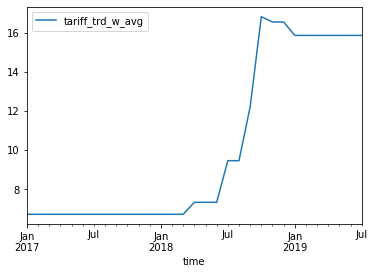

In [30]:
exp_trf_bynaics.groupby(["time"]).agg({"tariff_trd_w_avg": "mean"}).plot()

Looks like we accomplished this task. Just a couple of things to clean up then we are ready to move onto the next step. 

In [31]:
exp_trf_bynaics["time"] = exp_trf_bynaics.index.get_level_values(0)

In [32]:
exp_trf_bynaics = exp_trf_bynaics.droplevel(level=0)

In [33]:
exp_trf_bynaics.loc["111"]

,tariff_trd_w_avg,total_trade,china_trade,time
naics3,,,,
111,7.721464,6.603100e+09,2.109643e+09,2017-01-01
111,7.721464,6.065852e+09,1.364752e+09,2017-02-01
111,7.721464,6.286655e+09,9.556366e+08,2017-03-01
111,7.721464,5.212053e+09,5.722663e+08,2017-04-01
111,7.721464,4.819325e+09,4.427745e+08,2017-05-01
111,7.721464,4.621882e+09,3.576780e+08,2017-06-01
111,7.721464,4.728544e+09,5.627322e+08,2017-07-01
111,7.721464,4.352082e+09,7.052263e+08,2017-08-01
111,7.721464,4.921610e+09,1.279385e+09,2017-09-01


---

### Step 3 Merge trade data with the county data

This is the most time consuming step (interms of compuation time). So start with the county data set, `groupby` county, then apply a function which will create (i) time varying exports (which are constructed with the 2017 weightes) and (ii) time varying tariffs (also constructed using the 2017) weights. 

The final want is a big dataframe that has county, time, export exposure and tariff exposure. 

In [34]:
grp = df_county.groupby("area_fips")

In [35]:
grp.get_group("1001").head()

,area_fips,own_code,industry_code,agglvl_code,size_code,year,disclosure_code,annual_avg_estabs,annual_avg_emplvl,total_annual_wages,avg_annual_pay,sup_ind
3016,1001,5,111,75,0,2017,N,4,0,0,0,1
3026,1001,5,112,75,0,2017,NaN,3,27,848146,31905,1
3033,1001,5,113,75,0,2017,NaN,4,36,2901165,80032,1
3040,1001,5,115,75,0,2017,NaN,9,27,2007731,74132,1
3052,1001,5,212,75,0,2017,N,4,0,0,0,1


Below are the two key functions that deliver this. Basically it does the following: 

- Take the county level, merge it with the national level data set, so the resulting `df` has the county and nation. 
- Create the weights. 

- Then merge it with the exports, this will now be a df with exports varying over time, but with the fixed weights associated with each entry.

- Then aggregate the national exports by NAICS by the county level weights, giving a county level time series of exports.

---

**Updates**

- The tariff measure does the following: fix a county, take employment in industry $i$ and divide by total county employment, then sum up tariffs across industries with the weights being the county level share. The idea here is if all employment in a county is soy, then the "effective" tariff that the county faces is the soy tariff.

In equation terms: here $c$ is county, $i$ is industry, $n$, below is nation.

$\tau_c = \sum_{i}\frac{L_{ci}}{L_{c}} \tau_{i}$


- The export measure: What am I doing: take a county's employment in industry $i$ and divide by **national** level employment in industry $i$. Then a "county's" exports is the the sum across industries, weighted by the county's share of national employment in each industry. The idea here is, if a county's has all national level employment in an industry, all that industries exports will be assigned to that county.

$EX_c = \sum_{i}\frac{L_{ci}}{L_{ni}} EX_{i}$

- A second measure that I construct is I divide by total employment in the county to have a county per worker measure. 

$EX_c = \frac{1}{L_c}\sum_{i}\frac{L_{ci}}{L_{ni}} EX_{i} $

which after rearranging things, then looks close to the tariff measure, but on a per worker basis...

$EX_c = \sum_{i}\frac{L_{ci}}{L_{c}} \frac{EX_{i}}{L_{ni}}$

this last one makes the most sense because (i) it lines up with the tariff measure and (ii) respects the aggregate summing up constraint.

- This approach appears to be different than ADH? Need to investigate more closely. 



In [36]:
def create_trade_weights(df):
    # Takes in the county groupings and will return, for each county, a time series of export
    # exposure, tariffs, and other statistics. 

    new_df = df.merge(df_national[["nat_emplvl",
                                   "industry_code", "trd_wts"]],
                                  how = "outer", left_on = "industry_code", right_on = "industry_code")
    # Merge the nation with the county, why, we want to make sure all the naics codes are lined up properly
        
    new_df["emp_wts"] = (new_df.annual_avg_emplvl/new_df.nat_emplvl)
    
    
    # create the weights...
        
    foo_df = exp_trf_bynaics.merge(new_df[["emp_wts","trd_wts",
                                           "industry_code",
                                          "annual_avg_emplvl"]], left_index = True, right_on = "industry_code")  
    
    # Now each weight is for a NAICS code, we will merge it with the export trade data set, so for all naics, all time...
    # This is a big df whith all trade data and then the county's weights for each naics code
    
    foo_grp = foo_df.groupby("time")
    
    # group by time. 
    
    foo = foo_grp.apply(trade_by_naics)
    
    # Then for each time gropuing, we aggregate across the naics codes according to the weights above.
    
    foo = foo.droplevel(1)
    
    foo["fips"] = df["area_fips"].astype(str).iloc[0]
    
    foo["total_employment"] = new_df.annual_avg_emplvl.sum()
    
    return pd.DataFrame(foo)
    

In [37]:
def trade_by_naics(df):
    # Simple function just to test about aggregation 

    china_exp_pc = (1/df["annual_avg_emplvl"].sum())*(df["china_trade"]*df["emp_wts"]).sum()
    
    total_exp_pc = (1/df["annual_avg_emplvl"].sum())*(df["total_trade"]*df["emp_wts"]).sum()
    # the first term multiplies trade by the county's share of national level employment
    # then the outside term divides by number of workers in a county. 
    
    #tariff_nwt_pc = (1/df["annual_avg_emplvl"].sum())*(df["tariff_trd_w_avg"]*df["emp_wts"]).sum()
    # This is the measure that makes most sense, need to justify it...
    tariff =  ((df["annual_avg_emplvl"]*df["tariff_trd_w_avg"])/df["annual_avg_emplvl"].sum()).sum()
    # local employment share weighted tariff. So if all guys are in area are working in soy,
    # then they are facing the soybean tariff....
    
    foo = {"total_exp_pc": [total_exp_pc],
          "china_exp_pc": [china_exp_pc],
           "tariff": [tariff],
          "emplvl_2017": df["annual_avg_emplvl"].sum()}

    return pd.DataFrame(foo)

Then apply the function to the county groups

In [38]:
trade_county = grp.apply(create_trade_weights)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


And we are done and output the file to where we want it

In [39]:
trade_county.sort_values(by = ["tariff","emplvl_2017"], ascending = False).head(25)

total_exp_pc  china_exp_pc     tariff  emplvl_2017  \
area_fips time                                                             
29133     2019-03-01  10846.849861   1207.141946  32.841834        373.0   
          2019-04-01   9694.146530    677.704792  32.841834        373.0   
          2019-05-01   9539.483393   1231.086645  32.841834        373.0   
28143     2019-03-01  10846.849861   1207.141946  32.841834        311.0   
          2019-04-01   9694.146530    677.704792  32.841834        311.0   
          2019-05-01   9539.483393   1231.086645  32.841834        311.0   
28011     2019-03-01  10846.849861   1207.141946  32.841834        286.0   
          2019-04-01   9694.146530    677.704792  32.841834        286.0   
          2019-05-01   9539.483393   1231.086645  32.841834        286.0   
28027     2019-03-01  10846.849861   1207.141946  32.841834        275.0   
          2019-04-01   9694.146530    677.704792  32.841834        275.0   
          2019-05-01   9539.483393   1231.086645  32.841834        275.0   
4012      2019-03-01  10846.849861   1207.141946  32.841834        258.0   
          2019-04-01   9694.146530    677.704792  32.841834        258.0   
          2019-05-01   9539.483393   1231.086645  32.841834        258.0   
29143     2019-03-01  10846.849861   1207.141946  32.841834        227.0   
          2019-04-01   9694.146530    677.704792  32.841834        227.0   
          2019-05-01   9539.483393   1231.086645  32.841834        227.0   
53043     2019-03-01  10846.849861   1207.141946  32.841834        227.0   
          2019-04-01   9694.146530    677.704792  32.841834        227.0   
          2019-05-01   9539.483393   1231.086645  32.841834        227.0   
13101     2019-03-01  10846.849861   1207.141946  32.841834        216.0   
          2019-04-01   9694.146530    677.704792  32.841834        216.0   
          2019-05-01   9539.483393   1231.086645  32.841834        216.0   
8109      2019-03-01  10846.849861   1207.141946  32.841834        216.0   

                       fips  total_employment  
area_fips time                                 
29133     2019-03-01  29133            1890.0  
          2019-04-01  29133            1890.0  
          2019-05-01  29133            1890.0  
28143     2019-03-01  28143            5813.0  
          2019-04-01  28143            5813.0  
          2019-05-01  28143            5813.0  
28011     2019-03-01  28011            5285.0  
          2019-04-01  28011            5285.0  
          2019-05-01  28011            5285.0  
28027     2019-03-01  28027            4471.0  
          2019-04-01  28027            4471.0  
          2019-05-01  28027            4471.0  
4012      2019-03-01   4012            2180.0  
          2019-04-01   4012            2180.0  
          2019-05-01   4012            2180.0  
29143     2019-03-01  29143            3487.0  
          2019-04-01  29143            3487.0  
          2019-05-01  29143            3487.0  
53043     2019-03-01  53043            1132.0  
          2019-04-01  53043            1132.0  
          2019-05-01  53043            1132.0  
13101     2019-03-01  13101             411.0  
          2019-04-01  13101             411.0  
          2019-05-01  13101             411.0  
8109      2019-03-01   8109             699.0

**One more adjustment.** Notice that in the function, when we are merging, we are droping all the NAICS codes without trade. So these measures (total trade, china trade, and tariffs) are only conditional on being traded. This only matters in so far as the denominator, the ``df["annual_avg_emplvl"].sum()`` is concerned. 

To make the adjustment then, we multiply the employment measure in the denominator and then divide through by the ``total_employment`` measure. 

In [40]:
trade_county["tariff"] = (trade_county["emplvl_2017"]/
                              trade_county["total_employment"])*trade_county["tariff"]

trade_county["china_exp_pc"] = (trade_county["emplvl_2017"]/
                                    trade_county["total_employment"])*trade_county["china_exp_pc"]

trade_county["total_exp_pc"] = (trade_county["emplvl_2017"]/
                                    trade_county["total_employment"])*trade_county["total_exp_pc"]

In [41]:
os.getcwd()

'C:\\github\\consumption_and_tradewar'

In [42]:
file_path = os.getcwd() + "\\data"+ "\\total_trade_data.parquet"

pq.write_table(pa.Table.from_pandas(trade_county.reset_index()), file_path)

In [43]:
trade_county.sort_values(by = ["tariff","emplvl_2017"], ascending = False).head(50)

total_exp_pc  china_exp_pc     tariff  emplvl_2017  \
area_fips time                                                             
53023     2019-03-01  10846.849861   1207.141946  32.841834         37.0   
          2019-04-01   9694.146530    677.704792  32.841834         37.0   
          2019-05-01   9539.483393   1231.086645  32.841834         37.0   
28055     2019-03-01  10846.849861   1207.141946  32.841834         21.0   
          2019-04-01   9694.146530    677.704792  32.841834         21.0   
          2019-05-01   9539.483393   1231.086645  32.841834         21.0   
53023     2019-02-01  10402.686000   1602.779498  32.841833         37.0   
28055     2019-02-01  10402.686000   1602.779498  32.841833         21.0   
53023     2018-10-01  11029.821015    338.087532  32.841681         37.0   
          2018-11-01  11054.051521    245.380023  32.841681         37.0   
          2018-12-01  10317.462494    319.252072  32.841681         37.0   
          2019-06-01   9058.797470   1534.512372  32.841681         37.0   
          2019-07-01   8992.792004   1584.453257  32.841681         37.0   
28055     2018-10-01  11029.821015    338.087532  32.841681         21.0   
          2018-11-01  11054.051521    245.380023  32.841681         21.0   
          2018-12-01  10317.462494    319.252072  32.841681         21.0   
          2019-06-01   9058.797470   1534.512372  32.841681         21.0   
          2019-07-01   8992.792004   1584.453257  32.841681         21.0   
53023     2019-01-01  10693.516347   1053.866782  32.840465         37.0   
28055     2019-01-01  10693.516347   1053.866782  32.840465         21.0   
53023     2018-07-01   9740.286162    363.150134  32.809022         37.0   
          2018-08-01   8777.073228    247.688511  32.809022         37.0   
          2018-09-01   8483.895101    157.032476  32.809022         37.0   
28055     2018-07-01   9740.286162    363.150134  32.809022         21.0   
          2018-08-01   8777.073228    247.688511  32.809022         21.0   
          2018-09-01   8483.895101    157.032476  32.809022         21.0   
2013      2018-10-01   4118.669800    137.445642  30.494240       1895.0   
48229     2019-03-01   9936.045674   1105.778882  30.084123        120.0   
          2019-04-01   8880.134226    620.798282  30.084123        120.0   
          2019-05-01   8738.458070   1127.712958  30.084123        120.0   
          2019-02-01   9529.178015   1468.194960  30.084122        120.0   
          2018-10-01  10103.652838    309.698502  30.083982        120.0   
          2018-11-01  10125.848721    224.775593  30.083982        120.0   
          2018-12-01   9451.110681    292.444646  30.083982        120.0   
          2019-06-01   8298.135087   1405.660188  30.083982        120.0   
          2019-07-01   8237.672064   1451.407563  30.083982        120.0   
          2019-01-01   9795.587493    965.374152  30.082869        120.0   
          2018-07-01   8922.399538    332.656611  30.054066        120.0   
          2018-08-01   8040.067079    226.890239  30.054066        120.0   
          2018-09-01   7771.506963    143.846543  30.054066        120.0   
2013      2018-11-01   4151.164869    158.402245  29.496138       1895.0   
          2018-12-01   3888.608392    135.489747  29.496138       1895.0   
          2019-01-01   3866.228361    117.200215  29.472482       1895.0   
          2019-02-01   3623.922453    120.770348  29.464018       1895.0   
          2019-07-01   4024.540377    197.355531  29.463253       1895.0   
          2019-03-01   4233.512802    136.839704  29.463213       1895.0   
          2019-04-01   4061.746079    146.195539  29.463213       1895.0   
          2019-05-01   4200.469656    155.053854  29.463213       1895.0   
          2019-06-01   3961.584388    167.681782  29.463213       1895.0   
          2018-07-01   3905.080809    131.560611  27.842753       1895.0   

                       fips  total_employment  
area_fips time       

In [44]:
exposure = pd.qcut(trade_county.xs('2018-12-1', level=1).tariff, 4 ,labels = False)

In [45]:
most_exposed = exposure[exposure == 3].index.tolist()

trade_county.loc[most_exposed].xs('2018-12-1', level=1).tariff.mean()

6.515098948465189